In [3]:
import numpy as np
from sklearn.cluster import k_means
from sklearn.mixture import GaussianMixture

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from numpy.linalg import eig

# ------------------- Data -------------------
np.random.seed(42)

def make_blob(mean, cov, n):
    return np.random.multivariate_normal(mean, cov, n)

n_per = 250
X1 = make_blob([0, 0], [[1.2, 0.6],[0.6, 1.0]], n_per)
X2 = make_blob([6, 4], [[1.0, -0.3],[-0.3, 0.5]], n_per)
X3 = make_blob([-5, 5], [[0.5, 0],[0, 1.6]], n_per)
X = np.vstack([X1, X2, X3])

In [5]:
X[:5]

array([[-0.4326913 , -0.4936121 ],
       [-1.33624845,  0.26772172],
       [ 0.33963967,  0.07254156],
       [-1.92275518, -0.92353059],
       [ 0.22227565,  0.68691893]])

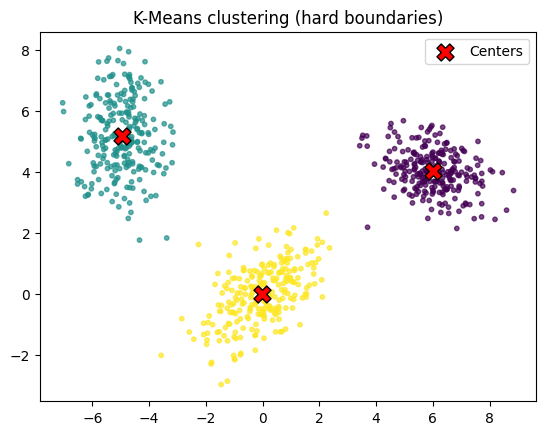

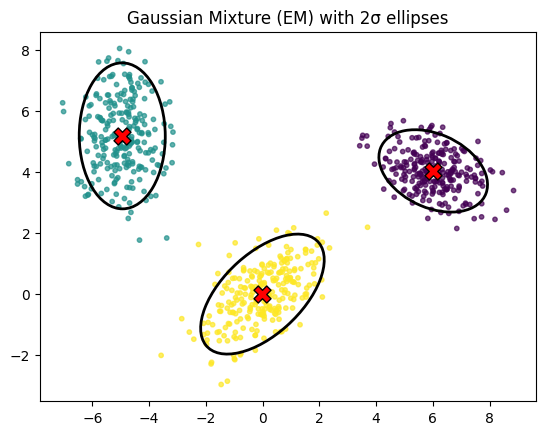

c:\Users\maahi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


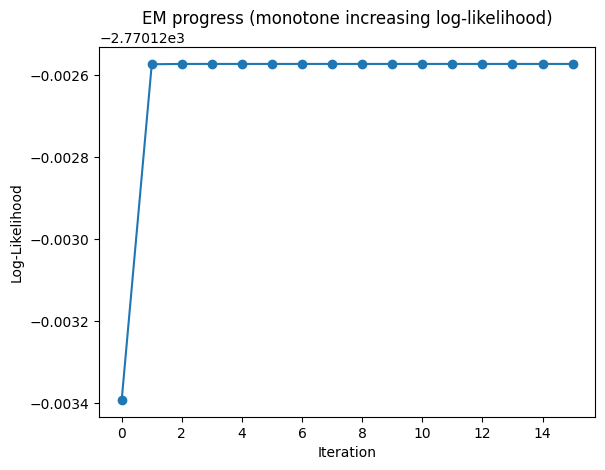

In [6]:
# ------------------- K-Means -------------------
k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

plt.figure()
plt.scatter(X[:,0], X[:,1], c=labels_kmeans, s=10, alpha=0.7)
plt.scatter(centers[:,0], centers[:,1], marker="X", s=150, c="red", edgecolor="k", label="Centers")
plt.title("K-Means clustering (hard boundaries)")
plt.legend()
plt.show()

# ------------------- GMM with EM -------------------
gmm = GaussianMixture(n_components=k, covariance_type="full", init_params="kmeans", random_state=42)
gmm.fit(X)

labels_gmm = gmm.predict(X)
means = gmm.means_
covs = gmm.covariances_

# Helper: draw covariance ellipses
def draw_cov_ellipse(ax, mean, cov, nsig=2.0, **kwargs):
    vals, vecs = eig(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * nsig * np.sqrt(vals.real)
    ellip = Ellipse(xy=mean, width=width, height=height, angle=theta, fill=False, **kwargs)
    ax.add_patch(ellip)

plt.figure()
ax = plt.gca()
ax.scatter(X[:,0], X[:,1], c=labels_gmm, s=10, alpha=0.7)
ax.scatter(means[:,0], means[:,1], marker="X", s=150, c="red", edgecolor="k")
for m, c in zip(means, covs):
    draw_cov_ellipse(ax, m, c, nsig=2.0, linewidth=2)
plt.title("Gaussian Mixture (EM) with 2σ ellipses")
plt.show()

# ------------------- EM log-likelihood progress -------------------
gmm_step = GaussianMixture(n_components=k, covariance_type="full", init_params="kmeans",
                           random_state=42, warm_start=True, max_iter=1)
gmm_step.fit(X)

history_ll = [gmm_step.score(X) * len(X)]
for _ in range(15):
    gmm_step.fit(X)
    history_ll.append(gmm_step.score(X) * len(X))

plt.figure()
plt.plot(history_ll, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.title("EM progress (monotone increasing log-likelihood)")
plt.show()

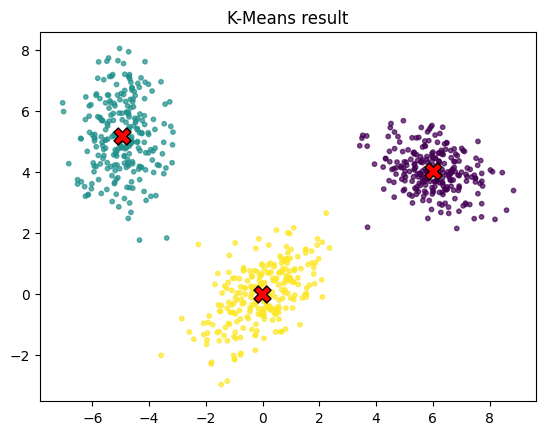

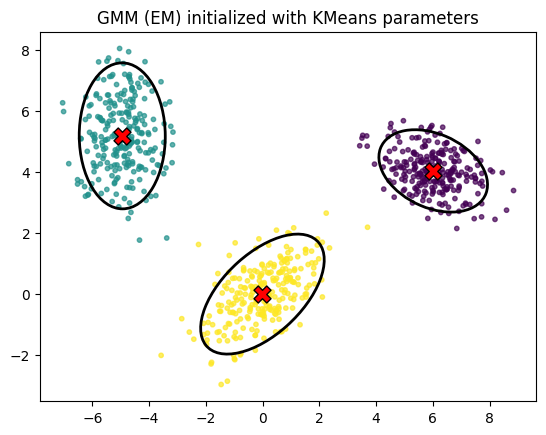

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from numpy.linalg import eig

# ---------- Data ----------
np.random.seed(42)
def make_blob(mean, cov, n=250):
    return np.random.multivariate_normal(mean, cov, n)

n_per = 250
X = np.vstack([
    make_blob([0, 0], [[1.2, 0.6],[0.6, 1.0]]),
    make_blob([6, 4], [[1.0, -0.3],[-0.3, 0.5]]),
    make_blob([-5, 5], [[0.5, 0],[0, 1.6]])
])

# ---------- K-Means ----------
k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

# Plot KMeans
plt.figure()
plt.scatter(X[:,0], X[:,1], c=labels_kmeans, s=10, alpha=0.7)
plt.scatter(centers[:,0], centers[:,1], marker="X", s=150, c="red", edgecolor="k")
plt.title("K-Means result")
plt.show()

# ---------- Build GMM initialization from KMeans ----------
weights_init = np.array([(labels_kmeans == i).sum() for i in range(k)]) / len(X)
means_init = centers
covs_init = []
for i in range(k):
    points = X[labels_kmeans == i]
    cov = np.cov(points.T) if len(points) > 1 else np.eye(X.shape[1])
    covs_init.append(cov)
covs_init = np.array(covs_init)

# ---------- Gaussian Mixture ----------
gmm = GaussianMixture(n_components=k, covariance_type="full", 
                      random_state=42, max_iter=200)
gmm.weights_init = weights_init
gmm.means_init = means_init
gmm.covariances_init = covs_init
# sklearn also requires precisions (inverse covariances) when giving covariances_init
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky
gmm.precisions_cholesky_ = _compute_precision_cholesky(covs_init, "full")

# Fit EM starting from KMeans params
gmm.fit(X)
labels_gmm = gmm.predict(X)

# ---------- Plot GMM result ----------
def draw_cov_ellipse(ax, mean, cov, nsig=2.0, **kwargs):
    vals, vecs = eig(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * nsig * np.sqrt(vals.real)
    ellip = Ellipse(xy=mean, width=width, height=height, angle=theta, fill=False, **kwargs)
    ax.add_patch(ellip)

plt.figure()
ax = plt.gca()
ax.scatter(X[:,0], X[:,1], c=labels_gmm, s=10, alpha=0.7)
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker="X", s=150, c="red", edgecolor="k")
for m, c in zip(gmm.means_, gmm.covariances_):
    draw_cov_ellipse(ax, m, c, nsig=2.0, linewidth=2)
plt.title("GMM (EM) initialized with KMeans parameters")
plt.show()


In [8]:
weightone = np.array([(labels_kmeans == i).sum() for i in range(k)]) / len(X)

print(weightone)

[0.33466667 0.33333333 0.332     ]


Epoch 1, Loss: 0.2722
Epoch 2, Loss: 0.0018
Epoch 3, Loss: 0.0002
Epoch 4, Loss: 0.0001
Epoch 5, Loss: 0.0000

Test Accuracy: 100.00%


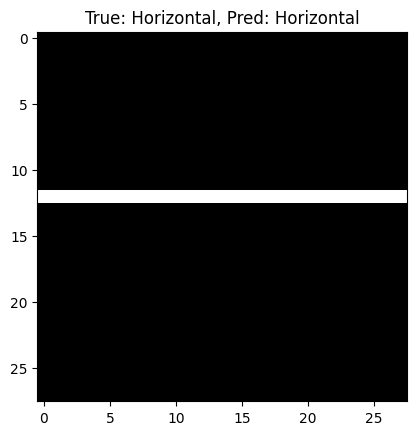

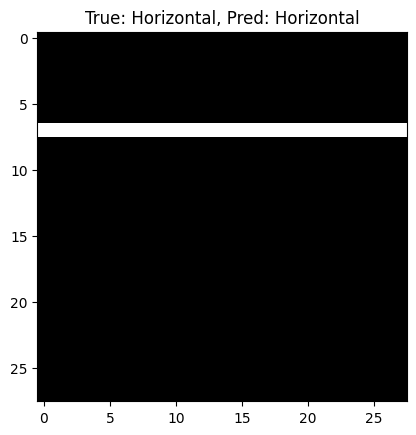

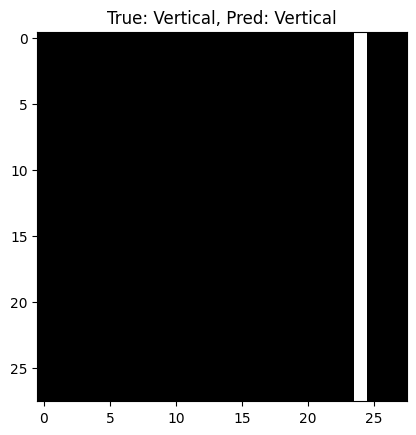

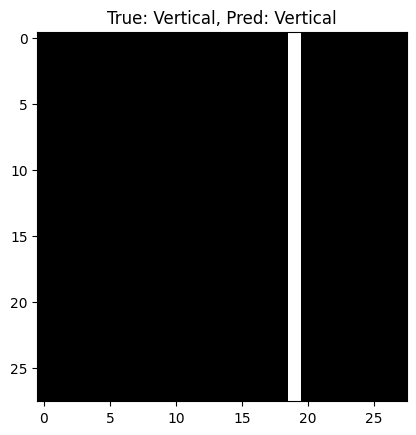

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ----------------------------
# Step 1: Generate synthetic dataset
# ----------------------------
def generate_line_image(size=28, orientation="horizontal"):
    img = np.zeros((size, size), dtype=np.float32)
    if orientation == "horizontal":
        row = np.random.randint(0, size)
        img[row, :] = 1.0
    elif orientation == "vertical":
        col = np.random.randint(0, size)
        img[:, col] = 1.0
    return img

def create_dataset(n_samples=2000, img_size=28):
    X, y = [], []
    for i in range(n_samples):
        if i % 2 == 0:
            X.append(generate_line_image(img_size, "horizontal"))
            y.append(0)  # 0 = horizontal
        else:
            X.append(generate_line_image(img_size, "vertical"))
            y.append(1)  # 1 = vertical
    return np.array(X), np.array(y)

X, y = create_dataset(2000, 28)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# Step 2: PyTorch Dataset
# ----------------------------
class LineDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images).unsqueeze(1)  # add channel dim [N,1,H,W]
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = LineDataset(X_train, y_train)
test_dataset = LineDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# ----------------------------
# Step 3: Define CNN model
# ----------------------------
class LineClassifier(nn.Module):
    def __init__(self):
        super(LineClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 2)  # 2 classes: horizontal, vertical

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LineClassifier().to(device)

# ----------------------------
# Step 4: Training setup
# ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----------------------------
# Step 5: Train the model
# ----------------------------
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Step 6: Evaluate
# ----------------------------
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")

# ----------------------------
# Step 7: Visualize prediction
# ----------------------------
def show_prediction(index=5):
    img = X_test[index]
    label = "Horizontal" if y_test[index] == 0 else "Vertical"
    
    with torch.no_grad():
        tensor_img = torch.tensor(img).unsqueeze(0).unsqueeze(0).to(device)
        output = model(tensor_img)
        pred = torch.argmax(output, dim=1).item()
        pred_label = "Horizontal" if pred == 0 else "Vertical"
    
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {label}, Pred: {pred_label}")
    plt.show()

show_prediction(20)
show_prediction(11)
show_prediction(1)
show_prediction(7)
